In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import struct
from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker
from ctapipe.calib.camera import DragonPedestal

In [2]:
path_to_data = os.path.join("/home", "pawel1", "Pulpit", "Astrophysics", "CTA", "dragon",
                            "data", "dane_lst", "20180705", "Date20180705.0000.fits.fz")

reader = LSTEventSource(input_url=path_to_data)
seeker = EventSeeker(reader)
ev = seeker[0]

num_modules = ev.lst.tel[0].svc.num_modules
print("numbers of modules: ", num_modules)

numbers of modules:  262


For instance, in this data you have 262 modules and numpy array with first_capacitor have 2096 elements.

In [ ]:
cap_data_numbers = ev.lst.tel[0].evt.first_capacitor_id.shape[0]
print(cap_data_numbers)
cap_data_numbers/num_modules

Data order of first capacitor id is the following one due to physical position of DRS4 chip:
[FirstCap0(HG0,1)]FirstCap1(LG0,1)][FirstCap2(HG2,3)][FirstCap3(LG2,3)][FirstCap4(HG4,5)][FirstCap5(LG4,5)][FirstCap6(HG6,7)][FirstCap7(LG6,7)]

Assume that you want read first capacitors for module 0 

In [ ]:
#fc - first capacitor, hg - high gain, lg - low gain
fc = np.zeros((2, 7))
hg = 0
lg = 1
first_cap = ev.lst.tel[0].evt.first_capacitor_id[0:8] # for module 1 you have to use: [8:16] ...
fc[hg, 0] = first_cap[0]
fc[hg, 1] = first_cap[0]
fc[hg, 2] = first_cap[1]
fc[hg, 3] = first_cap[1]
fc[hg, 4] = first_cap[2]
fc[hg, 5] = first_cap[2]
fc[hg, 6] = first_cap[3]

fc[lg, 0] = first_cap[4]
fc[lg, 1] = first_cap[4]
fc[lg, 2] = first_cap[5]
fc[lg, 3] = first_cap[5]
fc[lg, 4] = first_cap[6]
fc[lg, 5] = first_cap[6]
fc[lg, 6] = first_cap[7]

In [ ]:
print(fc)

In [ ]:
print("first cap high gain:", fc[0, :])
print("first cap low gain:", fc[1, :])

# Create binary file to substract pedestal

In [ ]:
number_modules = 4
ped = DragonPedestal()
PedList = []

for i in range(0, number_modules):
    reader = LSTEventSource(input_url=path_to_data)
    seeker = EventSeeker(reader)
    PedList.append(DragonPedestal())
    for j in range(0, 5000):
        ev = seeker[j]
        PedList[i].fill_pedestal_event(ev, nr=i)

    PedList[i].finalize_pedestal()

In [ ]:
plt.figure()
plt.plot(PedList[0].meanped[0, 0,:1024], marker='o')
plt.plot(PedList[1].meanped[0, 0,:1024], marker='o')
plt.show()

In [ ]:
f_out = open('pedestal_value.dat', 'wb')

#header
f_out.write(struct.pack('>B', 1)) # version 1
f_out.write(struct.pack('>H', 7)) #number of pixels
f_out.write(struct.pack('>H', 4096)) #number of samples
f_out.write(struct.pack('>H', 40)) # RoI

#high gain
for nr in range(0, number_modules):
    for pixel in range(0, 7):
        for value in (PedList[nr].meanped[0, pixel, :]):
            f_out.write(struct.pack('>H', int(value)))
        
    # low gain
    for pixel in range(0, 7):
        for value in (PedList[nr].meanped[1, pixel, :]):
            f_out.write(struct.pack('>H', int(value)))

f_out.close()        


with open("pedestal_value.dat", "rb") as binary_file:
    # Read the whole file at once
    data = binary_file.read()
    
    version = struct.unpack(">s", data[0:1])
    print("version: ",version)
    number_pixels = int.from_bytes(data[1:3], byteorder='big')
    print("number of pixels: ",number_pixels)
    number_samples = int.from_bytes(data[3:5], byteorder='big')
    print("number of samples: ",number_samples)
    RoI = int.from_bytes(data[5:7], byteorder='big')
    print("RoI: ", RoI)
    
    for i in range(7, 100, 2):
        value = int.from_bytes(data[i:i+2], byteorder='big')
        print(value)

In [ ]:
class Event():
    def __init__(self):
        self.waveform = np.zeros()
        self.first_cap = np.zeros()

class DRS4Pedestal():
    def __init__(self, path_to_file, nr):
        self.path = path_to_file
        self.nr = nr
        self.pedestal_value = np.zeros((self.nr, 2, 7, 4096))
    
    def read_binary_file(self):
        with open(self.path, "rb") as binary_file:
            # Read the whole file at once
            data = binary_file.read()
            
            pos = 7
            for i in range(0, nr+1):
                for gain in range(0, 2):
                    for pixel in range(0, 7):
                        for cap in range(0, 4096):
                            value = int.from_bytes(data[pos:pos+2], byteorder='big')
                            self.pedestal_value[i, gain, pixel, cap] = value
                            pos += 2
            

In [ ]:
os.path.getsize("pedestal_value.dat")

# Diffrent approach: MyEvent class

In [6]:
class DRS4Event():
    def __init__(self, num_modules):
        self.waveform = np.zeros((num_modules, 2, 7, 40))
        self.first_cap = np.zeros((num_modules, 2, 8))
        
        self.meanped = np.zeros((num_modules, 2, 7, 4096))
        self.numped = np.zeros((num_modules, 2, 7, 4096))
        self.rms = np.zeros((num_modules, 2, 7, 4096))
    
    def fill(self, ev):
        for nr in range(0, ev.lst.tel[0].svc.num_modules):
            self.waveform[nr, :, :, :] = ev.r0.tel[0].waveform[ :,nr * 7:(nr + 1)*7, :]
            self.first_cap[nr, :, :] = get_first_capacitor(ev, nr)
            
    def fill_pedestal_event(self, ev):
        size4drs = 4*1024
        
        for nr in range(0, ev.lst.tel[0].svc.num_modules):
            for i in range(0, 2)
                for j in range(0, 7):
                    for k in range(2, 38):
                    
        
            for j in range(0, self.n_channels):
                for k in range(2, self.RoI - 2):
                    # for high gain
                    position_hg = int((k + event.first_capacitor_high_gain[j]) % self.size4drs)
                    self.channel_pedestal_value_high_gain[j, position_hg] += event.samples_high_gain[j, k]
                    self.rms_high_gain[j, position_hg] += event.samples_high_gain[j, k]**2
                    self.number_of_event_high_gain[j, position_hg] += 1
            
    def pedestal(self, waveform, fc):
         for i in range(0, 2):
            for j in range(0, 7):
                fc = int(self.first_cap[i, j])
                for k in range(2, 38):
                    posads = int((k+fc)%self.size4drs)
                    val = waveform[i, j, k]
                    self.meanped[i, j, posads] += val
                    self.numped[i, j, posads] += 1
                    self.rms[i, j, posads] += val**2
                    
def get_first_capacitor(event, nr):
    hg = 0
    lg = 1
    fc = np.zeros((2, 8))
    first_cap = event.lst.tel[0].evt.first_capacitor_id[nr * 8:(nr + 1) * 8]
    for i, j in zip([0, 1, 2, 3, 4, 5, 6], [0, 0, 1, 1, 2, 2, 3]):
        fc[hg, i] = first_cap[j]
    for i, j in zip([0, 1, 2, 3, 4, 5, 6], [4, 4, 5, 5, 6, 6, 7]):
        fc[lg, i] = first_cap[j]
    return fc        
        

In [7]:
reader = LSTEventSource(input_url=path_to_data)
seeker = EventSeeker(reader)
ev = seeker[0]

Ev_drs4 = DRS4Event(ev.lst.tel[0].svc.num_modules)
Ev_drs4.fill(ev)

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/protozfits/__init__.py:56: UserWarning:         Multiple open zfits files at the same time are not supported.
        Reading from mutliple open tables at the same time will reset these
        tables continously and you will read always the same events.
        
  ''')


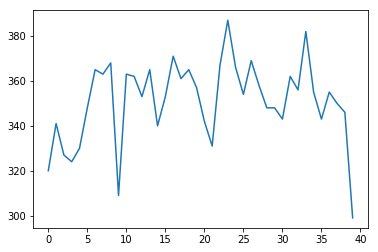

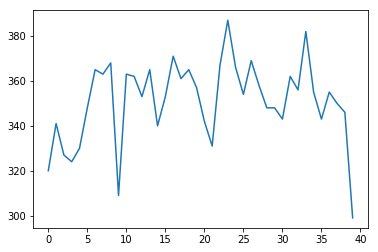

In [8]:
Ev_drs4.waveform
plt.plot(Ev_drs4.waveform[5, 0, 0, :])
plt.show()

plt.figure()
plt.plot(ev.r0.tel[0].waveform[0, 35, :])

In [ ]:
ev.lst.tel[0].evt.first_capacitor_id.shape

In [ ]:
nr = 0
gain = 0
ev.r0.tel[0].waveform[gain, nr * 7:(nr + 1)*7, :][0]

In [ ]:
ev.r0.tel[0].waveform.shape

In [9]:
Ev_drs4.first_cap

array([[[3074., 3074., 3075., ..., 3074., 3074.,    0.],
        [3075., 3075., 3075., ..., 3075., 3075.,    0.]],

       [[ 789.,  789.,  786., ...,  782.,  781.,    0.],
        [ 785.,  785.,  785., ...,  793.,  785.,    0.]],

       [[3834., 3834., 3835., ..., 3834., 3836.,    0.],
        [3836., 3836., 3836., ..., 3840., 3835.,    0.]],

       ...,

       [[ 199.,  199.,  198., ...,  193.,  201.,    0.],
        [ 197.,  197.,  195., ...,  197.,  195.,    0.]],

       [[2293., 2293., 2287., ..., 2290., 2287.,    0.],
        [2292., 2292., 2296., ..., 2286., 2290.,    0.]],

       [[2716., 2716., 2718., ..., 2716., 2720.,    0.],
        [2715., 2715., 2713., ..., 2719., 2718.,    0.]]])

In [13]:
print(ev.r0.tels_with_data)

[0]
